## **Experiment 1: Basic CNN, VGG166, ResNet50 & DenseNet121**

In [ ]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices("GPU"))

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR  = "/content/drive/MyDrive/archive/ODIR-5K/ODIR-5K"

# check folder
print(os.listdir(BASE_DIR))

TRAIN_DIR = os.path.join(BASE_DIR, "Training Images")
TEST_DIR  = os.path.join(BASE_DIR, "Testing Images")

META_PATH = os.path.join(BASE_DIR, "data.xlsx")

print("BASE_DIR :", BASE_DIR)
print("TRAIN_DIR:", TRAIN_DIR, os.path.exists(TRAIN_DIR))
print("TEST_DIR :", TEST_DIR,  os.path.exists(TEST_DIR))
print("META_PATH:", META_PATH, os.path.exists(META_PATH))
df = pd.read_excel(META_PATH)
df.head()
df.columns

# column name equal with file df
IMG_LEFT_COL  = "Left-Fundus"
IMG_RIGHT_COL = "Right-Fundus"
LABEL_COLS = ["N", "D", "G", "C", "A", "H", "M", "O"]
# left eye
left_df = df[[IMG_LEFT_COL] + LABEL_COLS].copy()
left_df = left_df.rename(columns={IMG_LEFT_COL: "image_name"})
left_df["eye"] = "L"

# right eye
right_df = df[[IMG_RIGHT_COL] + LABEL_COLS].copy()
right_df = right_df.rename(columns={IMG_RIGHT_COL: "image_name"})
right_df["eye"] = "R"

#preprocessing
# join
img_df = pd.concat([left_df, right_df], ignore_index=True)

# drop empty file name
img_df = img_df.dropna(subset=["image_name"]).reset_index(drop=True)

print("Total row (left+right):", len(img_df))
img_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['data.xlsx', 'Training Images', 'Testing Images']
BASE_DIR : /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K
TRAIN_DIR: /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/Training Images True
TEST_DIR : /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/Testing Images True
META_PATH: /content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/data.xlsx True
Total row (left+right): 7000


,image_name,N,D,G,C,A,H,M,O,eye
0,0_left.jpg,0,0,0,1,0,0,0,0,L
1,1_left.jpg,1,0,0,0,0,0,0,0,L
2,2_left.jpg,0,1,0,0,0,0,0,1,L
3,3_left.jpg,0,0,0,0,0,0,0,1,L
4,4_left.jpg,0,1,0,0,0,0,0,1,L


In [ ]:
# complete path to image file
img_df["img_path"] = img_df["image_name"].apply(
    lambda x: os.path.join(TRAIN_DIR, str(x))
)

# check sample
img_df[["image_name", "img_path"]].head()
img_df["exists"] = img_df["img_path"].apply(os.path.exists)
print(img_df["exists"].value_counts())

# keep file
img_df = img_df[img_df["exists"]].reset_index(drop=True)
img_df = img_df.drop(columns=["exists"])

print("Total sampel dengan file exist:", len(img_df))
img_df.head()

X_paths = img_df["img_path"].values
y       = img_df[LABEL_COLS].values.astype("float32")   # 8 label: N D G C A H M O

X_train, X_val, y_train, y_val = train_test_split(
    X_paths,
    y,
    test_size=0.2,
    random_state=42
)

len(X_train), len(X_val)

exists
True    7000
Name: count, dtype: int64
Total sampel dengan file exist: 7000


(5600, 1400)

In [ ]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

def load_image_and_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)   # if PNG, change decode_png
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = (train_ds
            .shuffle(1000)
            .map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds
          .map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

In [ ]:
num_labels = len(LABEL_COLS)  # 8

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_labels, activation="sigmoid")  # multi-label
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,728 (84.86 MB)

 Trainable params: 22,246,728 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 5  # can add

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.3204 - loss: 0.3875 - val_accuracy: 0.3879 - val_loss: 0.3525
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.3811 - loss: 0.3513 - val_accuracy: 0.3950 - val_loss: 0.3463
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.3872 - loss: 0.3453 - val_accuracy: 0.3900 - val_loss: 0.3419
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.3847 - loss: 0.3386 - val_accuracy: 0.3979 - val_loss: 0.3409
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.4067 - loss: 0.3345 - val_accuracy: 0.4043 - val_loss: 0.3339


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))
y_true_base = y_true.copy()
y_pred_base = y_pred.copy()

Micro F1 : 0.10596026490066225
Macro F1 : 0.06959099798516143
Micro Precision: 0.5925925925925926
Micro Recall   : 0.05818181818181818

Per-label report:

              precision    recall  f1-score   support

           N       0.59      0.17      0.26       438
           D       0.58      0.03      0.06       442
           G       0.00      0.00      0.00        85
           C       0.50      0.03      0.06        91
           A       0.00      0.00      0.00        61
           H       0.50      0.02      0.04        46
           M       0.83      0.07      0.13        69
           O       0.00      0.00      0.00       418

   micro avg       0.59      0.06      0.11      1650
   macro avg       0.38      0.04      0.07      1650
weighted avg       0.39      0.06      0.10      1650
 samples avg       0.07      0.07      0.07      1650



In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# =========================
# 1. BUILD VGG16 BASE MODEL
# =========================

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Freeze all layers VGG16 (Stage 1: feature extractor)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D(name="gap")(x)
x = Dense(256, activation="relu", name="fc_256")(x)
x = Dropout(0.5, name="dropout")(x)

# Multi-label 8 class → sigmoid
outputs = Dense(num_labels, activation="sigmoid", name="output")(x)

model = Model(inputs=base_model.input, outputs=outputs, name="VGG16_ODIR")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("=== VGG16 MODEL SUMMARY (STAGE 1, FROZEN) ===")
model.summary()

# =========================
# 2. CALLBACKS STAGE 1
# =========================

early_stop1 = EarlyStopping(
    monitor="val_loss",
    patience=3,                 # if 3 epoch val_loss didn't change → stop
    restore_best_weights=True,
    verbose=1
)

checkpoint1 = ModelCheckpoint(
    "vgg16_stage1_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# =========================
# 3. TRAINING STAGE 1
# =========================

EPOCHS_STAGE1 = 10

print("\n=== TRAINING VGG16 STAGE 1 (FROZEN) ===\n")
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop1, checkpoint1]
)

# =========================
# 4. FINE-TUNING STAGE 2
# =========================

# Open last layer VGG16 (example the last 4th layer)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# After change trainable → must recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("\n=== VGG16 MODEL SUMMARY (STAGE 2, PARTIALLY UNFROZEN) ===")
model.summary()

early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint2 = ModelCheckpoint(
    "vgg16_stage2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

EPOCHS_STAGE2 = 8

print("\n=== TRAINING VGG16 STAGE 2 (FINE-TUNING) ===\n")
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop2, checkpoint2]
)

# =========================
# 5. SAVE FINAL MODEL
# =========================

model.save("vgg16_final_odir5k.h5")
print("\n✅ VGG16 final model saved as 'vgg16_final_odir5k.h5'")

=== VGG16 MODEL SUMMARY (STAGE 1, FROZEN) ===


Model: "VGG16_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_256 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,072 (56.64 MB)

 Trainable params: 133,384 (521.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


=== TRAINING VGG16 STAGE 1 (FROZEN) ===

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2750 - loss: 0.4926
Epoch 1: val_loss improved from inf to 0.35574, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - accuracy: 0.2751 - loss: 0.4922 - val_accuracy: 0.3493 - val_loss: 0.3557
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2812 - loss: 0.3776
Epoch 2: val_loss improved from 0.35574 to 0.35239, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.2812 - loss: 0.3776 - val_accuracy: 0.3750 - val_loss: 0.3524
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2887 - loss: 0.3697
Epoch 3: val_loss improved from 0.35239 to 0.35077, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.2888 - loss: 0.3697 - val_accuracy: 0.3793 - val_loss: 0.3508
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3020 - loss: 0.3641
Epoch 4: val_loss improved from 0.35077 to 0.34920, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.3021 - loss: 0.3641 - val_accuracy: 0.3807 - val_loss: 0.3492
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3208 - loss: 0.3598
Epoch 5: val_loss improved from 0.34920 to 0.34776, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3208 - loss: 0.3598 - val_accuracy: 0.3729 - val_loss: 0.3478
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3354 - loss: 0.3565
Epoch 6: val_loss improved from 0.34776 to 0.34588, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3354 - loss: 0.3565 - val_accuracy: 0.3886 - val_loss: 0.3459
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3397 - loss: 0.3534
Epoch 7: val_loss improved from 0.34588 to 0.34506, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.3397 - loss: 0.3534 - val_accuracy: 0.3886 - val_loss: 0.3451
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3236 - loss: 0.3559
Epoch 8: val_loss improved from 0.34506 to 0.34336, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.3236 - loss: 0.3558 - val_accuracy: 0.3871 - val_loss: 0.3434
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3433 - loss: 0.3509
Epoch 9: val_loss improved from 0.34336 to 0.34202, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.3433 - loss: 0.3509 - val_accuracy: 0.3893 - val_loss: 0.3420
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3349 - loss: 0.3522
Epoch 10: val_loss improved from 0.34202 to 0.34146, saving model to vgg16_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.3349 - loss: 0.3522 - val_accuracy: 0.3864 - val_loss: 0.3415
Restoring model weights from the end of the best epoch: 10.

=== VGG16 MODEL SUMMARY (STAGE 2, PARTIALLY UNFROZEN) ===


Model: "VGG16_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_256 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,072 (56.64 MB)

 Trainable params: 7,212,808 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)


=== TRAINING VGG16 STAGE 2 (FINE-TUNING) ===

Epoch 1/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3714 - loss: 0.3416
Epoch 1: val_loss improved from inf to 0.32363, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.3714 - loss: 0.3416 - val_accuracy: 0.4000 - val_loss: 0.3236
Epoch 2/8
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3995 - loss: 0.3317
Epoch 2: val_loss improved from 0.32363 to 0.31819, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.3994 - loss: 0.3317 - val_accuracy: 0.4200 - val_loss: 0.3182
Epoch 3/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4018 - loss: 0.3287
Epoch 3: val_loss improved from 0.31819 to 0.31551, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4018 - loss: 0.3287 - val_accuracy: 0.4321 - val_loss: 0.3155
Epoch 4/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4129 - loss: 0.3244
Epoch 4: val_loss improved from 0.31551 to 0.31285, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4128 - loss: 0.3244 - val_accuracy: 0.4407 - val_loss: 0.3129
Epoch 5/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4237 - loss: 0.3202
Epoch 5: val_loss improved from 0.31285 to 0.31111, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.4237 - loss: 0.3202 - val_accuracy: 0.4443 - val_loss: 0.3111
Epoch 6/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4293 - loss: 0.3168
Epoch 6: val_loss improved from 0.31111 to 0.30792, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4292 - loss: 0.3168 - val_accuracy: 0.4493 - val_loss: 0.3079
Epoch 7/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4293 - loss: 0.3150
Epoch 7: val_loss improved from 0.30792 to 0.30755, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4294 - loss: 0.3150 - val_accuracy: 0.4393 - val_loss: 0.3075
Epoch 8/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4305 - loss: 0.3129
Epoch 8: val_loss improved from 0.30755 to 0.30632, saving model to vgg16_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.4306 - loss: 0.3129 - val_accuracy: 0.4471 - val_loss: 0.3063
Restoring model weights from the end of the best epoch: 8.



✅ VGG16 final model saved as 'vgg16_final_odir5k.h5'


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# prediksi in val_ds
y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))  # threshold 0.5

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))
y_true_vgg = y_true.copy()
y_pred_vgg = y_pred.copy()

Micro F1 : 0.21902874132804756
Macro F1 : 0.21645589390501277
Micro Precision: 0.6005434782608695
Micro Recall   : 0.13393939393939394

Per-label report:

              precision    recall  f1-score   support

           N       0.53      0.02      0.04       438
           D       0.52      0.27      0.36       442
           G       1.00      0.01      0.02        85
           C       1.00      0.33      0.50        91
           A       0.00      0.00      0.00        61
           H       0.00      0.00      0.00        46
           M       0.83      0.71      0.77        69
           O       0.40      0.02      0.05       418

   micro avg       0.60      0.13      0.22      1650
   macro avg       0.53      0.17      0.22      1650
weighted avg       0.52      0.13      0.18      1650
 samples avg       0.15      0.13      0.14      1650



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# =========================
# 1) BUILD RESNET50 BASE
# =========================
base_model_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Stage 1: freeze all layers
for layer in base_model_resnet.layers:
    layer.trainable = False

x = base_model_resnet.output
x = GlobalAveragePooling2D(name="gap")(x)
x = Dense(256, activation="relu", name="fc_256")(x)
x = Dropout(0.5, name="dropout")(x)
outputs = Dense(num_labels, activation="sigmoid", name="output")(x)  # multi-label

model_resnet = Model(inputs=base_model_resnet.input, outputs=outputs, name="ResNet50_ODIR")

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("=== RESNET50 SUMMARY (STAGE 1: FROZEN) ===")
model_resnet.summary()

# =========================
# 2) CALLBACKS STAGE 1
# =========================
early_stop1 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint1 = ModelCheckpoint(
    "resnet50_stage1_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# =========================
# 3) TRAIN STAGE 1
# =========================
EPOCHS_STAGE1 = 10

print("\n=== TRAINING RESNET50 STAGE 1 (FROZEN) ===\n")
history_resnet_stage1 = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop1, checkpoint1]
)

# =========================
# 4) FINE-TUNE STAGE 2
# =========================
# Open several last layer (konservatif)
for layer in base_model_resnet.layers[-20:]:
    layer.trainable = True

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint2 = ModelCheckpoint(
    "resnet50_stage2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

EPOCHS_STAGE2 = 8

print("\n=== TRAINING RESNET50 STAGE 2 (FINE-TUNING) ===\n")
history_resnet_stage2 = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop2, checkpoint2]
)

# =========================
# 5) SAVE FINAL
# =========================
model_resnet.save("resnet50_final_odir5k.h5")
print("\n✅ ResNet50 final saved as 'resnet50_final_odir5k.h5'")


=== RESNET50 SUMMARY (STAGE 1: FROZEN) ===


Model: "ResNet50_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


=== TRAINING RESNET50 STAGE 1 (FROZEN) ===

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2408 - loss: 0.5395
Epoch 1: val_loss improved from inf to 0.35715, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 161ms/step - accuracy: 0.2409 - loss: 0.5389 - val_accuracy: 0.3171 - val_loss: 0.3571
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2839 - loss: 0.3868
Epoch 2: val_loss improved from 0.35715 to 0.35576, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.2840 - loss: 0.3867 - val_accuracy: 0.3157 - val_loss: 0.3558
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2993 - loss: 0.3778
Epoch 3: val_loss improved from 0.35576 to 0.35538, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.2993 - loss: 0.3778 - val_accuracy: 0.3157 - val_loss: 0.3554
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3016 - loss: 0.3748
Epoch 4: val_loss did not improve from 0.35538
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.3017 - loss: 0.3748 - val_accuracy: 0.3157 - val_loss: 0.3554
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3009 - loss: 0.3702
Epoch 5: val_loss improved from 0.35538 to 0.35466, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.3010 - loss: 0.3702 - val_accuracy: 0.3707 - val_loss: 0.3547
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3083 - loss: 0.3690
Epoch 6: val_loss improved from 0.35466 to 0.35449, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.3083 - loss: 0.3690 - val_accuracy: 0.3793 - val_loss: 0.3545
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3185 - loss: 0.3669
Epoch 7: val_loss improved from 0.35449 to 0.35430, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.3185 - loss: 0.3669 - val_accuracy: 0.3500 - val_loss: 0.3543
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3239 - loss: 0.3674
Epoch 8: val_loss improved from 0.35430 to 0.35376, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.3239 - loss: 0.3673 - val_accuracy: 0.3657 - val_loss: 0.3538
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3038 - loss: 0.3641
Epoch 9: val_loss improved from 0.35376 to 0.35367, saving model to resnet50_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.3038 - loss: 0.3641 - val_accuracy: 0.3807 - val_loss: 0.3537
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3017 - loss: 0.3643
Epoch 10: val_loss did not improve from 0.35367
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3017 - loss: 0.3643 - val_accuracy: 0.3686 - val_loss: 0.3541
Restoring model weights from the end of the best epoch: 9.

=== TRAINING RESNET50 STAGE 2 (FINE-TUNING) ===

Epoch 1/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2943 - loss: 0.4074
Epoch 1: val_loss improved from inf to 0.38585, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 43s 146ms/step - accuracy: 0.2945 - loss: 0.4072 - val_accuracy: 0.3157 - val_loss: 0.3859
Epoch 2/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3611 - loss: 0.3593
Epoch 2: val_loss improved from 0.38585 to 0.36395, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.3611 - loss: 0.3593 - val_accuracy: 0.3443 - val_loss: 0.3640
Epoch 3/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3441 - loss: 0.3548
Epoch 3: val_loss improved from 0.36395 to 0.34747, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.3441 - loss: 0.3548 - val_accuracy: 0.3836 - val_loss: 0.3475
Epoch 4/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3741 - loss: 0.3526
Epoch 4: val_loss improved from 0.34747 to 0.34331, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3741 - loss: 0.3525 - val_accuracy: 0.3950 - val_loss: 0.3433
Epoch 5/8
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3881 - loss: 0.3456
Epoch 5: val_loss improved from 0.34331 to 0.34267, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3881 - loss: 0.3456 - val_accuracy: 0.3900 - val_loss: 0.3427
Epoch 6/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3913 - loss: 0.3422
Epoch 6: val_loss improved from 0.34267 to 0.33636, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.3913 - loss: 0.3421 - val_accuracy: 0.3807 - val_loss: 0.3364
Epoch 7/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3973 - loss: 0.3401
Epoch 7: val_loss did not improve from 0.33636
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3974 - loss: 0.3401 - val_accuracy: 0.3764 - val_loss: 0.3389
Epoch 8/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4043 - loss: 0.3352
Epoch 8: val_loss improved from 0.33636 to 0.33534, saving model to resnet50_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4043 - loss: 0.3352 - val_accuracy: 0.3743 - val_loss: 0.3353
Restoring model weights from the end of the best epoch: 8.



✅ ResNet50 final saved as 'resnet50_final_odir5k.h5'


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model_resnet.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))

# ambil report versi dict
report_dict = classification_report(
    y_true, y_pred,
    target_names=LABEL_COLS,
    output_dict=True,
    zero_division=0
)

# table per label (take only label, not avg)
df = pd.DataFrame(report_dict).T.loc[LABEL_COLS, ["recall", "f1-score"]]

y_true_res = y_true.copy()
y_pred_res = y_pred.copy()


Micro F1 : 0.1444155844155844
Macro F1 : 0.11572991270358893
Micro Precision: 0.5054545454545455
Micro Recall   : 0.08424242424242424

Per-label report:

              precision    recall  f1-score   support

           N       0.48      0.20      0.28       438
           D       0.46      0.05      0.09       442
           G       0.00      0.00      0.00        85
           C       1.00      0.01      0.02        91
           A       0.00      0.00      0.00        61
           H       1.00      0.02      0.04        46
           M       0.75      0.35      0.48        69
           O       0.25      0.00      0.01       418

   micro avg       0.51      0.08      0.14      1650
   macro avg       0.49      0.08      0.12      1650
weighted avg       0.43      0.08      0.12      1650
 samples avg       0.10      0.09      0.09      1650



In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# =========================
# 1) BUILD DENSENET121 BASE
# =========================
base_model_dense = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Stage 1: freeze semua layer
for layer in base_model_dense.layers:
    layer.trainable = False

x = base_model_dense.output
x = GlobalAveragePooling2D(name="gap")(x)
x = Dense(256, activation="relu", name="fc_256")(x)
x = Dropout(0.5, name="dropout")(x)
outputs = Dense(num_labels, activation="sigmoid", name="output")(x)  # multi-label

model_dense = Model(inputs=base_model_dense.input, outputs=outputs, name="DenseNet121_ODIR")

model_dense.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("=== DENSENET121 SUMMARY (STAGE 1: FROZEN) ===")
model_dense.summary()

# =========================
# 2) CALLBACKS STAGE 1
# =========================
early_stop1 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint1 = ModelCheckpoint(
    "densenet121_stage1_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# =========================
# 3) TRAIN STAGE 1
# =========================
EPOCHS_STAGE1 = 10

print("\n=== TRAINING DENSENET121 STAGE 1 (FROZEN) ===\n")
history_dense_stage1 = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop1, checkpoint1]
)

# =========================
# 4) FINE-TUNE STAGE 2
# =========================
for layer in base_model_dense.layers[-30:]:
    layer.trainable = True

model_dense.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop2 = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint2 = ModelCheckpoint(
    "densenet121_stage2_best.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

EPOCHS_STAGE2 = 8

print("\n=== TRAINING DENSENET121 STAGE 2 (FINE-TUNING) ===\n")
history_dense_stage2 = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop2, checkpoint2]
)

# =========================
# 5) SAVE FINAL
# =========================
model_dense.save("densenet121_final_odir5k.h5")
print("\n✅ DenseNet121 final saved as 'densenet121_final_odir5k.h5'")

=== DENSENET121 SUMMARY (STAGE 1: FROZEN) ===


Model: "DenseNet121_ODIR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,960 (27.85 MB)

 Trainable params: 264,456 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


=== TRAINING DENSENET121 STAGE 1 (FROZEN) ===

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2151 - loss: 0.5045
Epoch 1: val_loss improved from inf to 0.32990, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 77s 266ms/step - accuracy: 0.2154 - loss: 0.5040 - val_accuracy: 0.3657 - val_loss: 0.3299
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3276 - loss: 0.3582
Epoch 2: val_loss improved from 0.32990 to 0.32006, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3277 - loss: 0.3581 - val_accuracy: 0.3821 - val_loss: 0.3201
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3557 - loss: 0.3438
Epoch 3: val_loss improved from 0.32006 to 0.31484, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3558 - loss: 0.3438 - val_accuracy: 0.4121 - val_loss: 0.3148
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3940 - loss: 0.3337
Epoch 4: val_loss improved from 0.31484 to 0.31076, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.3939 - loss: 0.3337 - val_accuracy: 0.4364 - val_loss: 0.3108
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4113 - loss: 0.3275
Epoch 5: val_loss improved from 0.31076 to 0.30782, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4113 - loss: 0.3275 - val_accuracy: 0.4521 - val_loss: 0.3078
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4064 - loss: 0.3251
Epoch 6: val_loss improved from 0.30782 to 0.30580, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4065 - loss: 0.3251 - val_accuracy: 0.4571 - val_loss: 0.3058
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4236 - loss: 0.3209
Epoch 7: val_loss improved from 0.30580 to 0.30386, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.4236 - loss: 0.3209 - val_accuracy: 0.4529 - val_loss: 0.3039
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4416 - loss: 0.3171
Epoch 8: val_loss improved from 0.30386 to 0.30240, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4416 - loss: 0.3171 - val_accuracy: 0.4479 - val_loss: 0.3024
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4310 - loss: 0.3150
Epoch 9: val_loss improved from 0.30240 to 0.30223, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4311 - loss: 0.3150 - val_accuracy: 0.4536 - val_loss: 0.3022
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4389 - loss: 0.3148
Epoch 10: val_loss improved from 0.30223 to 0.29961, saving model to densenet121_stage1_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.4389 - loss: 0.3148 - val_accuracy: 0.4571 - val_loss: 0.2996
Restoring model weights from the end of the best epoch: 10.

=== TRAINING DENSENET121 STAGE 2 (FINE-TUNING) ===

Epoch 1/8
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3671 - loss: 0.3796
Epoch 1: val_loss improved from inf to 0.30329, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 75s 234ms/step - accuracy: 0.3674 - loss: 0.3794 - val_accuracy: 0.4500 - val_loss: 0.3033
Epoch 2/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4132 - loss: 0.3276
Epoch 2: val_loss improved from 0.30329 to 0.30009, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4132 - loss: 0.3276 - val_accuracy: 0.4536 - val_loss: 0.3001
Epoch 3/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4448 - loss: 0.3174
Epoch 3: val_loss improved from 0.30009 to 0.29850, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4448 - loss: 0.3174 - val_accuracy: 0.4579 - val_loss: 0.2985
Epoch 4/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4408 - loss: 0.3111
Epoch 4: val_loss improved from 0.29850 to 0.29719, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4408 - loss: 0.3111 - val_accuracy: 0.4636 - val_loss: 0.2972
Epoch 5/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4514 - loss: 0.3077
Epoch 5: val_loss improved from 0.29719 to 0.29627, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4513 - loss: 0.3077 - val_accuracy: 0.4621 - val_loss: 0.2963
Epoch 6/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4387 - loss: 0.3110
Epoch 6: val_loss improved from 0.29627 to 0.29553, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4387 - loss: 0.3110 - val_accuracy: 0.4643 - val_loss: 0.2955
Epoch 7/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4648 - loss: 0.3031
Epoch 7: val_loss improved from 0.29553 to 0.29499, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.4648 - loss: 0.3031 - val_accuracy: 0.4614 - val_loss: 0.2950
Epoch 8/8
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4565 - loss: 0.3029
Epoch 8: val_loss improved from 0.29499 to 0.29452, saving model to densenet121_stage2_best.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.4565 - loss: 0.3029 - val_accuracy: 0.4629 - val_loss: 0.2945
Restoring model weights from the end of the best epoch: 8.



✅ DenseNet121 final saved as 'densenet121_final_odir5k.h5'


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true_list, y_pred_list = [], []

for x_batch, y_batch in val_ds:
    preds = model_dense.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append((preds >= 0.5).astype(int))

y_true = np.vstack(y_true_list)
y_pred = np.vstack(y_pred_list)

print("Micro F1 :", f1_score(y_true, y_pred, average="micro"))
print("Macro F1 :", f1_score(y_true, y_pred, average="macro"))
print("Micro Precision:", precision_score(y_true, y_pred, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred, target_names=LABEL_COLS, zero_division=0))
y_true_den = y_true.copy()
y_pred_den = y_pred.copy()

Micro F1 : 0.301255230125523
Macro F1 : 0.2842246161151154
Micro Precision: 0.6467065868263473
Micro Recall   : 0.19636363636363635

Per-label report:

              precision    recall  f1-score   support

           N       0.57      0.26      0.36       438
           D       0.61      0.21      0.31       442
           G       0.75      0.04      0.07        85
           C       0.92      0.64      0.75        91
           A       0.00      0.00      0.00        61
           H       0.00      0.00      0.00        46
           M       0.82      0.68      0.75        69
           O       0.40      0.02      0.04       418

   micro avg       0.65      0.20      0.30      1650
   macro avg       0.51      0.23      0.28      1650
weighted avg       0.54      0.20      0.26      1650
 samples avg       0.23      0.20      0.21      1650



# Experiment 2: DenseNet121 Improve

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

def preprocess_for_densenet(img, label):
    img = tf.cast(img, tf.float32)
    img = densenet_preprocess(img)
    return img, label

train_ds_dn = train_ds.map(preprocess_for_densenet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_dn   = val_ds.map(preprocess_for_densenet,   num_parallel_calls=tf.data.AUTOTUNE)

train_ds_dn = train_ds_dn.prefetch(tf.data.AUTOTUNE)
val_ds_dn   = val_ds_dn.prefetch(tf.data.AUTOTUNE)

In [ ]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)

        bce = -(y_true * tf.math.log(y_pred) +
                (1 - y_true) * tf.math.log(1 - y_pred))

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)

        return tf.reduce_mean(alpha_factor * modulating_factor * bce)
    return loss
pr_auc = tf.keras.metrics.AUC(
    curve="PR",
    multi_label=True,
    num_labels=num_labels,
    name="pr_auc"
)

model_dense.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[pr_auc]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint("densenet121_best_final.h5", monitor="val_pr_auc",
                    mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_pr_auc", mode="max",
                  patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_pr_auc", mode="max",
                      factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

history_final = model_dense.fit(
    train_ds_dn,
    validation_data=val_ds_dn,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0407 - pr_auc: 0.1599
Epoch 1: val_pr_auc improved from -inf to 0.20091, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 77s 242ms/step - loss: 0.0407 - pr_auc: 0.1599 - val_loss: 0.0386 - val_pr_auc: 0.2009 - learning_rate: 1.0000e-04
Epoch 2/15
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0360 - pr_auc: 0.1924
Epoch 2: val_pr_auc improved from 0.20091 to 0.25909, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0360 - pr_auc: 0.1925 - val_loss: 0.0340 - val_pr_auc: 0.2591 - learning_rate: 1.0000e-04
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0351 - pr_auc: 0.2257
Epoch 3: val_pr_auc improved from 0.25909 to 0.27178, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.0351 - pr_auc: 0.2257 - val_loss: 0.0334 - val_pr_auc: 0.2718 - learning_rate: 1.0000e-04
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0344 - pr_auc: 0.2563
Epoch 4: val_pr_auc improved from 0.27178 to 0.30683, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0344 - pr_auc: 0.2562 - val_loss: 0.0330 - val_pr_auc: 0.3068 - learning_rate: 1.0000e-04
Epoch 5/15
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0342 - pr_auc: 0.2477
Epoch 5: val_pr_auc improved from 0.30683 to 0.31710, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.0342 - pr_auc: 0.2477 - val_loss: 0.0326 - val_pr_auc: 0.3171 - learning_rate: 1.0000e-04
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0340 - pr_auc: 0.2613
Epoch 6: val_pr_auc improved from 0.31710 to 0.32284, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0340 - pr_auc: 0.2613 - val_loss: 0.0324 - val_pr_auc: 0.3228 - learning_rate: 1.0000e-04
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0338 - pr_auc: 0.2652
Epoch 7: val_pr_auc improved from 0.32284 to 0.32455, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.0338 - pr_auc: 0.2652 - val_loss: 0.0328 - val_pr_auc: 0.3245 - learning_rate: 1.0000e-04
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0335 - pr_auc: 0.2820
Epoch 8: val_pr_auc improved from 0.32455 to 0.34286, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0335 - pr_auc: 0.2820 - val_loss: 0.0321 - val_pr_auc: 0.3429 - learning_rate: 1.0000e-04
Epoch 9/15
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0329 - pr_auc: 0.3124
Epoch 9: val_pr_auc improved from 0.34286 to 0.34450, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.0329 - pr_auc: 0.3124 - val_loss: 0.0322 - val_pr_auc: 0.3445 - learning_rate: 1.0000e-04
Epoch 10/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0329 - pr_auc: 0.3201
Epoch 10: val_pr_auc improved from 0.34450 to 0.35686, saving model to densenet121_best_final.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0329 - pr_auc: 0.3201 - val_loss: 0.0319 - val_pr_auc: 0.3569 - learning_rate: 1.0000e-04
Epoch 11/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0327 - pr_auc: 0.3268
Epoch 11: val_pr_auc did not improve from 0.35686
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0327 - pr_auc: 0.3267 - val_loss: 0.0328 - val_pr_auc: 0.3442 - learning_rate: 1.0000e-04
Epoch 12/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0324 - pr_auc: 0.3197
Epoch 12: val_pr_auc did not improve from 0.35686

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 0.0324 - pr_auc: 0.3198 - val_loss: 0.0323 - val_pr_auc: 0.3511 - learning_rate: 1.0000e-04
Epoch 13/15
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0320 - pr_auc: 0.3519
Epoch 13: val_pr_auc did not improve from 0.35686
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0320 - pr_auc: 0.3519 - val_

In [ ]:
# find the best threshold
y_true_list = []
y_prob_list = []

for x_batch, y_batch in val_ds_dn:
    preds = model_dense.predict(x_batch, verbose=0)
    y_true_list.append(y_batch.numpy())
    y_prob_list.append(preds)

y_true = np.vstack(y_true_list)
y_prob = np.vstack(y_prob_list)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

best_th, best_f1 = None, -1
for th in np.arange(0.05, 0.55, 0.05):
    y_pred = (y_prob >= th).astype(int)
    f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print("Best threshold:", best_th)
print("Best Micro F1:", best_f1)

y_true shape: (1400, 8)
y_prob shape: (1400, 8)
Best threshold: 0.3
Best Micro F1: 0.4729024488157367


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

y_pred_final = (y_prob >= 0.3).astype(int)

print("Micro Precision:", precision_score(y_true, y_pred_final, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true, y_pred_final, average="micro", zero_division=0))
print("Micro F1       :", f1_score(y_true, y_pred_final, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true, y_pred_final, target_names=LABEL_COLS, zero_division=0))

y_true_den_imp = y_true.copy()
y_pred_den_imp = y_pred_final.copy()

Micro Precision: 0.35354141656662663
Micro Recall   : 0.713939393939394
Micro F1       : 0.4729024488157367

Per-label report:

              precision    recall  f1-score   support

           N       0.34      0.89      0.50       438
           D       0.36      0.91      0.51       442
           G       0.28      0.21      0.24        85
           C       0.46      0.55      0.50        91
           A       0.00      0.00      0.00        61
           H       0.33      0.11      0.16        46
           M       0.56      0.67      0.61        69
           O       0.34      0.63      0.44       418

   micro avg       0.35      0.71      0.47      1650
   macro avg       0.33      0.50      0.37      1650
weighted avg       0.34      0.71      0.45      1650
 samples avg       0.37      0.74      0.47      1650



# **Comparison Graph Per Model**

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def micro_metrics(y_true, y_pred):
    return {
        "Micro Precision": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "Micro Recall": recall_score(y_true, y_pred, average="micro", zero_division=0),
        "Micro F1": f1_score(y_true, y_pred, average="micro", zero_division=0),
    }

results = []

results.append({"Model":"Base line",   **micro_metrics(y_true_base, y_pred_base)})
results.append({"Model":"VGG16",       **micro_metrics(y_true_vgg, y_pred_vgg)})
results.append({"Model":"ResNet50",    **micro_metrics(y_true_res, y_pred_res)})
results.append({"Model":"DenseNet121", **micro_metrics(y_true_den, y_pred_den)})
results.append({"Model":"DenseNet121 Improve", **micro_metrics(y_true_den_imp, y_pred_den_imp)})

df_res = pd.DataFrame(results).sort_values("Micro F1", ascending=False).reset_index(drop=True)
df_res

,Model,Micro Precision,Micro Recall,Micro F1
0,DenseNet121 Improve,0.353541,0.713939,0.472902
1,DenseNet121,0.646707,0.196364,0.301255
2,VGG16,0.600543,0.133939,0.219029
3,ResNet50,0.505455,0.084242,0.144416
4,Base line,0.592593,0.058182,0.105960


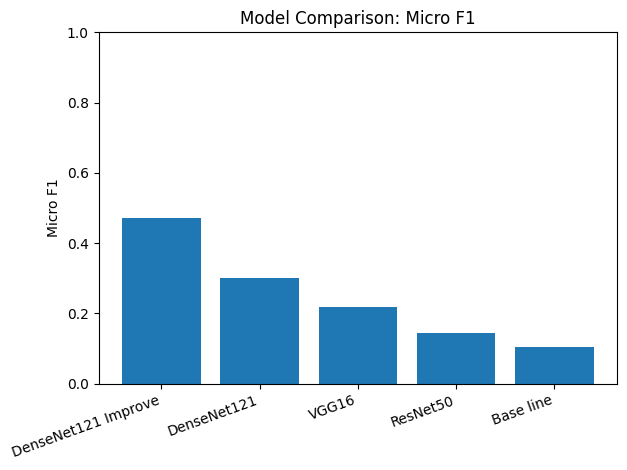

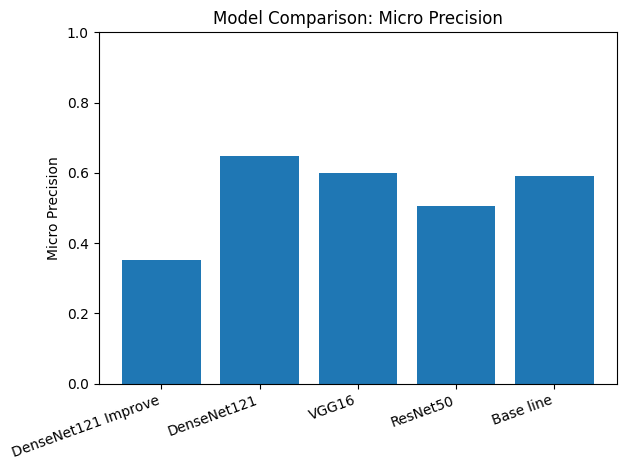

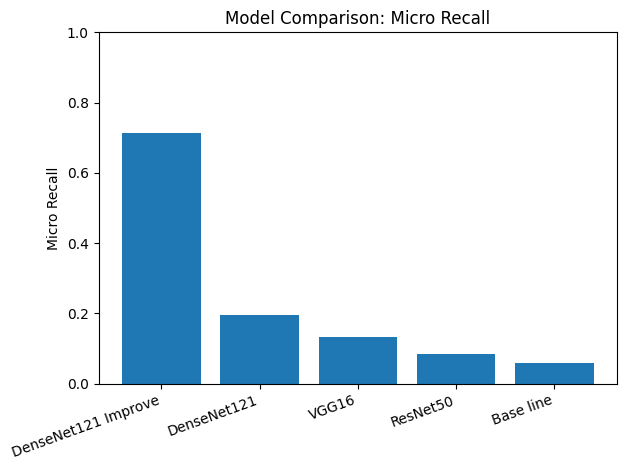

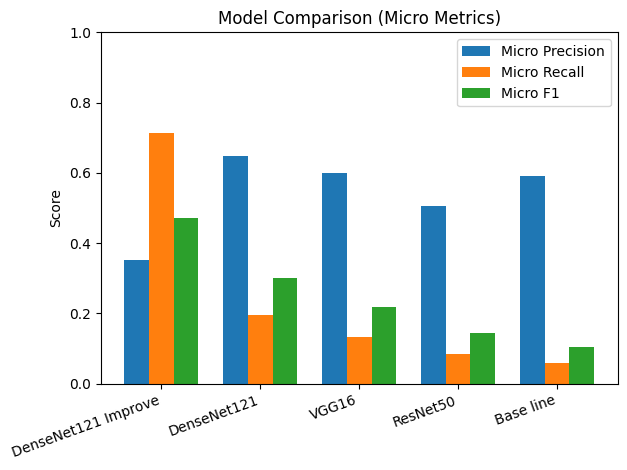

In [ ]:
for m in ["Micro F1", "Micro Precision", "Micro Recall"]:
    plt.figure()
    plt.bar(df_res["Model"], df_res[m])
    plt.ylim(0, 1)
    plt.title(f"Model Comparison: {m}")
    plt.ylabel(m)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

plt.figure()
x = range(len(df_res))
w = 0.25

plt.bar([i - w for i in x], df_res["Micro Precision"], width=w, label="Micro Precision")
plt.bar(x,                   df_res["Micro Recall"],    width=w, label="Micro Recall")
plt.bar([i + w for i in x], df_res["Micro F1"],         width=w, label="Micro F1")

plt.ylim(0, 1)
plt.xticks(list(x), df_res["Model"], rotation=20, ha="right")
plt.title("Model Comparison (Micro Metrics)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_res.to_csv("model_comparison_micro_metrics.csv",index=False)
print('Saved:model_comparison_micro_metrics.csv')

Saved:model_comparison_micro_metrics.csv


In [ ]:
[k for k in globals().keys() if "model" in k.lower()]

['models',
 'model',
 'Model',
 'ModelCheckpoint',
 'base_model',
 'base_model_resnet',
 'model_resnet',
 'base_model_dense',
 'model_dense']

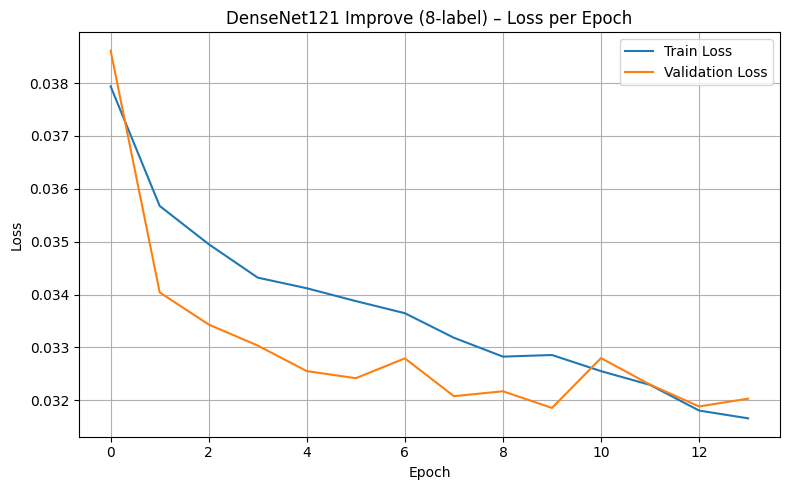

In [ ]:
#loss per Epoch
plt.figure(figsize=(8,5))
plt.plot(history_final.history["loss"], label="Train Loss")
plt.plot(history_final.history["val_loss"], label="Validation Loss")
plt.title("DenseNet121 Improve (8-label) – Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

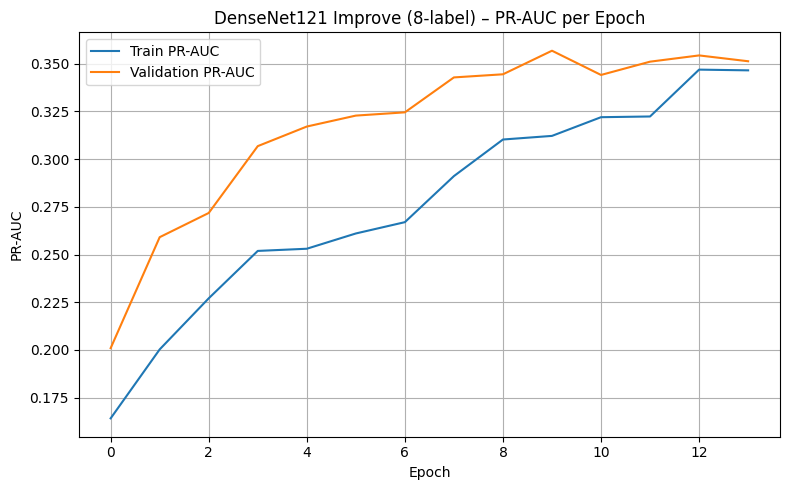

In [ ]:
#PR-AUC per Epoch
plt.figure(figsize=(8,5))
plt.plot(history_final.history["pr_auc"], label="Train PR-AUC")
plt.plot(history_final.history["val_pr_auc"], label="Validation PR-AUC")
plt.title("DenseNet121 Improve (8-label) – PR-AUC per Epoch")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
LABEL_COLS_8 = ["N", "D", "G", "C", "A", "H", "M", "O"]

precision_list = []
recall_list = []
f1_list = []

for i in range(len(LABEL_COLS_8)):
    precision_list.append(
        precision_score(y_true_den_imp[:, i], y_pred_den_imp[:, i], zero_division=0)
    )
    recall_list.append(
        recall_score(y_true_den_imp[:, i], y_pred_den_imp[:, i], zero_division=0)
    )
    f1_list.append(
        f1_score(y_true_den_imp[:, i], y_pred_den_imp[:, i], zero_division=0)
    )

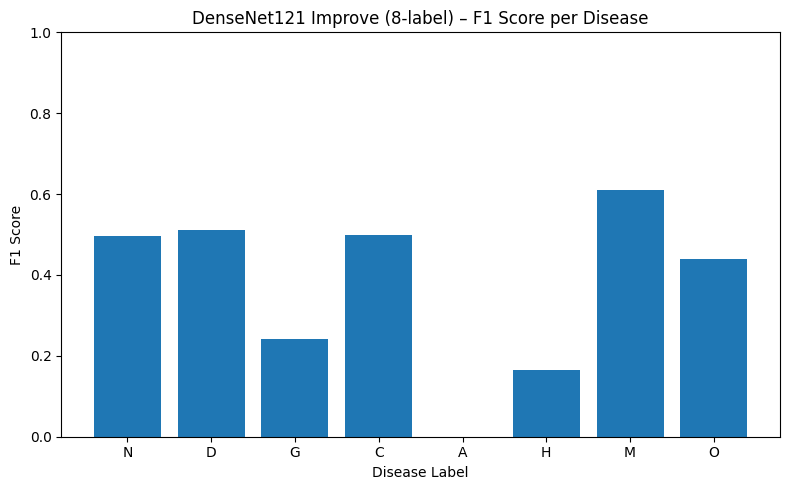

In [ ]:
#Bar Chart F1 score per label
plt.figure(figsize=(8,5))
plt.bar(LABEL_COLS_8, f1_list)
plt.ylim(0, 1)
plt.title("DenseNet121 Improve (8-label) – F1 Score per Disease")
plt.xlabel("Disease Label")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

# **Experiment 3 : DenseNet121 Label 6**


In [ ]:
# mapping index dari LABEL_COLS
idx = {name: i for i, name in enumerate(LABEL_COLS)}

def combine_labels(y):
    other_new = (
        (y[:, idx["O"]] == 1) |
        (y[:, idx["A"]] == 1) |
        (y[:, idx["H"]] == 1)
    ).astype(int)

    return np.stack([
        y[:, idx["N"]],
        y[:, idx["D"]],
        y[:, idx["G"]],
        y[:, idx["C"]],
        y[:, idx["M"]],
        other_new
    ], axis=1)

In [ ]:
y_train_6 = combine_labels(y_train)
y_val_6   = combine_labels(y_val)

print("Old:", y_train.shape)
print("New:", y_train_6.shape)

Old: (5600, 8)
New: (5600, 6)


In [ ]:
train_ds_6 = tf.data.Dataset.from_tensor_slices((X_train, y_train_6))
val_ds_6   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_6))

train_ds_6 = train_ds_6.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_6   = val_ds_6.map(load_image_and_label,   num_parallel_calls=tf.data.AUTOTUNE)

train_ds_6 = train_ds_6.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_6   = val_ds_6.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model_dn6 = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

for layer in base_model_dn6.layers:
    layer.trainable = False

x = base_model_dn6.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation="sigmoid")(x)  # <-- 6 label!

model_dn6 = Model(inputs=base_model_dn6.input, outputs=outputs)

model_dn6.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_dn6.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,301,446 (27.85 MB)

 Trainable params: 263,942 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history_dn6 = model_dn6.fit(
    train_ds_6,
    validation_data=val_ds_6,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
    ]
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 70s 240ms/step - accuracy: 0.2589 - loss: 0.5539 - val_accuracy: 0.3864 - val_loss: 0.3916
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.3557 - loss: 0.4150 - val_accuracy: 0.3986 - val_loss: 0.3778
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.3693 - loss: 0.3975 - val_accuracy: 0.4429 - val_loss: 0.3724
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.3845 - loss: 0.3907 - val_accuracy: 0.4479 - val_loss: 0.3680
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.4083 - loss: 0.3836 - val_accuracy: 0.4571 - val_loss: 0.3645
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.4161 - loss: 0.3801 - val_accuracy: 0.4450 - val_loss: 0.3619
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.4297 - loss: 0.3728 - val_accuracy: 0.4779 - val_loss: 0.3621
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.4215 - loss: 0

In [ ]:
from sklearn.metrics import f1_score, classification_report

LABEL_COLS_6 = ["N","D","G","C","M","Other_new"]

y_true_list, y_prob_list = [], []

for xb, yb in val_ds_6:
    p = model_dn6.predict(xb, verbose=0)
    y_true_list.append(yb.numpy())
    y_prob_list.append(p)

y_true_6 = np.vstack(y_true_list)
y_prob_6 = np.vstack(y_prob_list)

# threshold default dulu
y_pred_6 = (y_prob_6 >= 0.5).astype(int)

print("Micro F1:", f1_score(y_true_6, y_pred_6, average="micro", zero_division=0))
print("\nReport:\n")
print(classification_report(y_true_6, y_pred_6, target_names=LABEL_COLS_6, zero_division=0))

Micro F1: 0.27121951219512197

Report:

              precision    recall  f1-score   support

           N       0.58      0.13      0.21       438
           D       0.60      0.13      0.22       442
           G       1.00      0.01      0.02        85
           C       0.95      0.65      0.77        91
           M       0.93      0.59      0.73        69
   Other_new       0.57      0.12      0.20       514

   micro avg       0.68      0.17      0.27      1639
   macro avg       0.77      0.27      0.36      1639
weighted avg       0.64      0.17      0.25      1639
 samples avg       0.19      0.17      0.17      1639



In [ ]:
best_th, best_f1 = None, -1
for th in np.arange(0.05, 0.55, 0.05):
    y_pred = (y_prob_6 >= th).astype(int)
    f1 = f1_score(y_true_6, y_pred, average="micro", zero_division=0)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print("Best threshold:", best_th)
print("Best Micro F1:", best_f1)

Best threshold: 0.3
Best Micro F1: 0.547641073080481


In [ ]:
TH6 = 0.2777
y_pred_6_final = (y_prob_6 >= TH6).astype(int)

print("Micro Precision:", precision_score(y_true_6, y_pred_6_final, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true_6, y_pred_6_final, average="micro", zero_division=0))
print("Micro F1       :", f1_score(y_true_6, y_pred_6_final, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true_6, y_pred_6_final, target_names=LABEL_COLS_6, zero_division=0))

Micro Precision: 0.4219787516600266
Micro Recall   : 0.7754728492983527
Micro F1       : 0.5465491292195227

Per-label report:

              precision    recall  f1-score   support

           N       0.39      0.84      0.54       438
           D       0.40      0.76      0.53       442
           G       0.45      0.16      0.24        85
           C       0.78      0.77      0.77        91
           M       0.76      0.72      0.74        69
   Other_new       0.41      0.84      0.55       514

   micro avg       0.42      0.78      0.55      1639
   macro avg       0.53      0.68      0.56      1639
weighted avg       0.44      0.78      0.54      1639
 samples avg       0.44      0.79      0.54      1639



## ***Try threshold per label***

In [ ]:
LABEL_COLS_6 = ["N","D","G","C","M","Other_new"]
label_idx = {label: i for i, label in enumerate(LABEL_COLS_6)}

best_thresholds = {}

for label in LABEL_COLS_6:
    i = label_idx[label]
    best_f1, best_th = -1, 0.5

    for th in np.arange(0.05, 0.55, 0.05):
        y_pred_label = (y_prob_6[:, i] >= th).astype(int)
        f1 = f1_score(y_true_6[:, i], y_pred_label, zero_division=0)

        if f1 > best_f1:
            best_f1, best_th = f1, th

    best_thresholds[label] = best_th
    print(f"{label}: best_th={best_th:.2f}, best_f1={best_f1:.3f}")

y_pred_pl = np.zeros_like(y_prob_6, dtype=int)

for label, th in best_thresholds.items():
    i = label_idx[label]
    y_pred_pl[:, i] = (y_prob_6[:, i] >= th).astype(int)


print("Micro Precision:", precision_score(y_true_6, y_pred_pl, average="micro", zero_division=0))
print("Micro Recall   :", recall_score(y_true_6, y_pred_pl, average="micro", zero_division=0))
print("Micro F1       :", f1_score(y_true_6, y_pred_pl, average="micro", zero_division=0))
print("\nPer-label report:\n")
print(classification_report(y_true_6, y_pred_pl, target_names=LABEL_COLS_6, zero_division=0))

N: best_th=0.25, best_f1=0.544
D: best_th=0.30, best_f1=0.529
G: best_th=0.20, best_f1=0.385
C: best_th=0.40, best_f1=0.802
M: best_th=0.40, best_f1=0.764
Other_new: best_th=0.30, best_f1=0.554
Micro Precision: 0.43195063421323276
Micro Recall   : 0.7687614399023796
Micro F1       : 0.553116769095698

Per-label report:

              precision    recall  f1-score   support

           N       0.39      0.91      0.54       438
           D       0.42      0.71      0.53       442
           G       0.42      0.35      0.38        85
           C       0.92      0.71      0.80        91
           M       0.87      0.68      0.76        69
   Other_new       0.43      0.79      0.55       514

   micro avg       0.43      0.77      0.55      1639
   macro avg       0.57      0.69      0.60      1639
weighted avg       0.46      0.77      0.56      1639
 samples avg       0.46      0.79      0.55      1639



# **Prediction**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[OK] Using model: /content/densenet121_best_final.h5
[INFO] Scanning: 1000 images
[OK] Found 9 images with MIN_PROB >= 0.80
[OK] Saved: outputs/inference_sure/grid_sure_thresholded.png


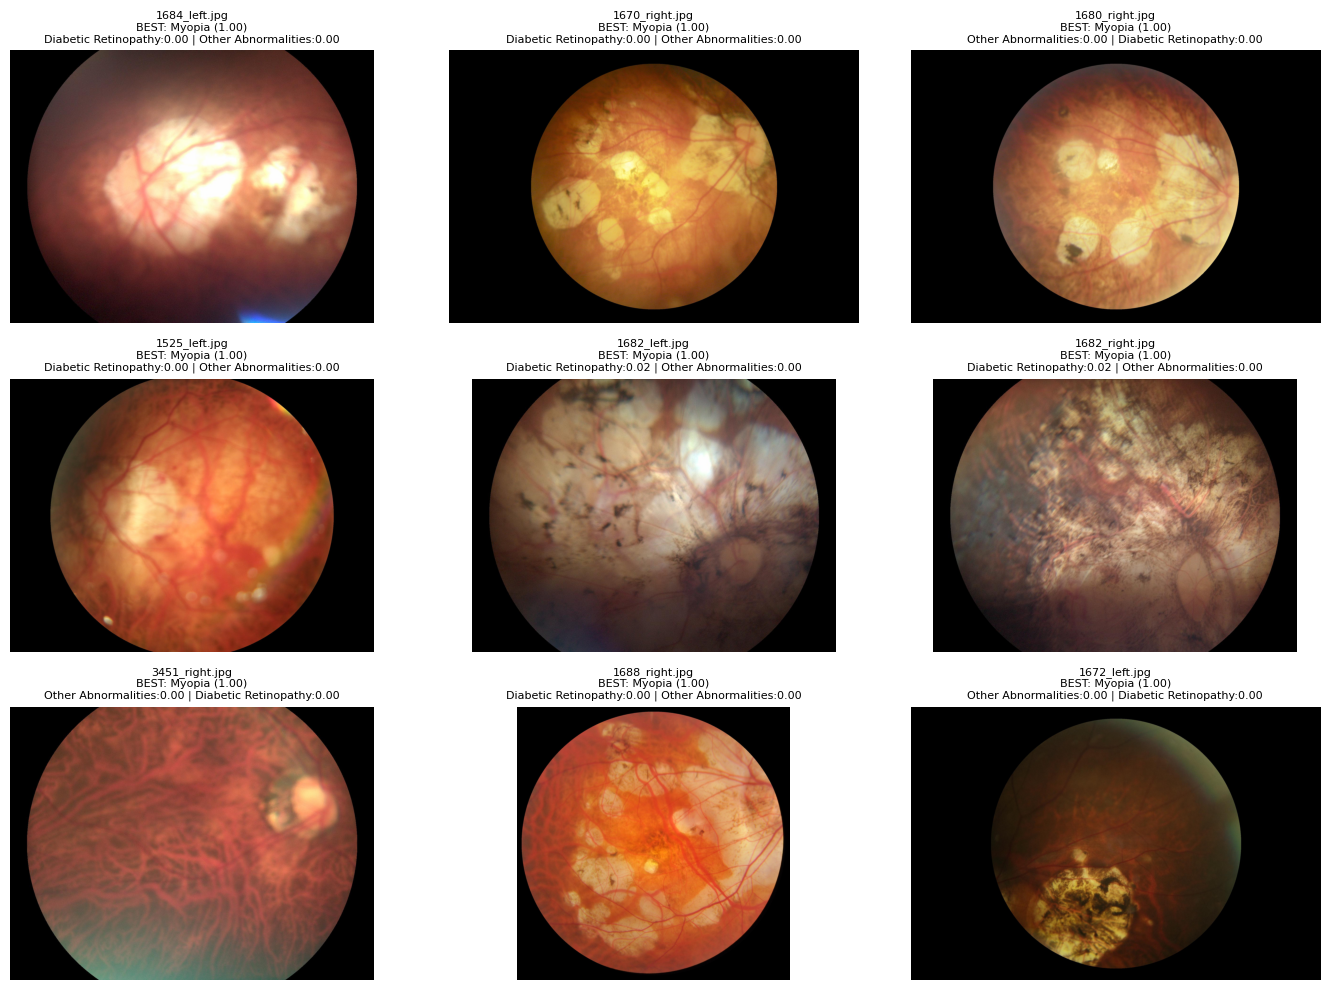

In [ ]:
import os, glob, shutil, heapq
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# 0) Drive + dataset path
drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/archive/ODIR-5K/ODIR-5K"
TEST_DIR = os.path.join(BASE_DIR, "Testing Images")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"TEST_DIR not found: {TEST_DIR}")

# 1) Use DenseNet improved model
preferred = "/content/drive/MyDrive/retina_project/models/densenet121_best_final.h5"
if os.path.exists(preferred):
    model_path = preferred
else:
    def score(p):
        n = os.path.basename(p).lower()
        s = 0
        for kw,w in [("densenet",5),("best",3),("final",3),("121",2)]:
            if kw in n: s += w
        return s
    cands = glob.glob("/content/*.h5") + glob.glob("/content/drive/MyDrive/**/*.h5", recursive=True)
    if len(cands) == 0:
        raise FileNotFoundError()
    model_path = sorted(cands, key=score, reverse=True)[0]

print("[OK] Using model:", model_path)

# 2) Labels
LABELS = ["N","D","G","C","A","H","M","O"]
name_map = {
    "D": "Diabetic Retinopathy",
    "G": "Glaucoma",
    "C": "Cataract",
    "A": "AMD",
    "H": "Hypertensive Retinopathy",
    "M": "Myopia",
    "O": "Other Abnormalities",
}
DISEASE_ONLY = ["D","G","C","A","H","M","O"]  # exclude Normal

# 3) Load model
model = tf.keras.models.load_model(model_path, compile=False)

# 4) Params (edit here)
IMG_SIZE = 224
SCAN_N   = 1200      # scan first N images
TAKE_K   = 9         # show 9 images
BATCH    = 24

MIN_PROB_START = 0.80
MIN_PROB_MIN   = 0.50
STEP_DOWN      = 0.05

# 5) List images
all_files = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))])
if len(all_files) == 0:
    raise FileNotFoundError()

all_files = all_files[:min(len(all_files), SCAN_N)]
all_paths = [os.path.join(TEST_DIR, f) for f in all_files]
print("[INFO] Scanning:", len(all_paths), "images")

# helper: heap keep top-k
def push_top(heap, item, k):
    if len(heap) < k:
        heapq.heappush(heap, item)
    else:
        if item[0] > heap[0][0]:
            heapq.heapreplace(heap, item)

# 6) Scan with threshold selection (auto lower until enough)
selected = []
min_prob = MIN_PROB_START

while True:
    top = []  # (best_p, path, probs)
    for i in range(0, len(all_paths), BATCH):
        batch_paths = all_paths[i:i+BATCH]
        X = []
        for p in batch_paths:
            img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
            arr = np.asarray(img, dtype=np.float32)
            arr = densenet_preprocess(arr)
            X.append(arr)
        X = np.stack(X, axis=0)

        probs_batch = model.predict(X, verbose=0)
        for p, probs in zip(batch_paths, probs_batch):
            prob_dict = {LABELS[j]: float(probs[j]) for j in range(len(LABELS))}
            best_d = max(DISEASE_ONLY, key=lambda k: prob_dict[k])
            best_p = prob_dict[best_d]

            # threshold selection here
            if best_p >= min_prob:
                push_top(top, (best_p, p, probs), TAKE_K)

    selected = sorted(top, key=lambda x: x[0], reverse=True)

    if len(selected) >= TAKE_K:
        print(f"[OK] Found {len(selected)} images with MIN_PROB >= {min_prob:.2f}")
        break

    if min_prob <= MIN_PROB_MIN:
        print(f"[WARN] Only found {len(selected)} images even at MIN_PROB={min_prob:.2f}.")
        break

    min_prob -= STEP_DOWN
    print(f"[INFO] Not enough images. Lowering MIN_PROB -> {min_prob:.2f}")

if len(selected) == 0:
    raise RuntimeError()

# 7) Plot grid
rows, cols = 3, 3
plt.figure(figsize=(14, 10))

for idx, (best_p, path, probs) in enumerate(selected[:TAKE_K], 1):
    img_pil = Image.open(path).convert("RGB")
    prob_dict = {LABELS[j]: float(probs[j]) for j in range(len(LABELS))}

    top3 = sorted([(k, prob_dict[k]) for k in DISEASE_ONLY], key=lambda x: x[1], reverse=True)[:3]
    line1 = os.path.basename(path)
    line2 = f"BEST: {name_map[top3[0][0]]} ({top3[0][1]:.2f})"
    line3 = f"{name_map[top3[1][0]]}:{top3[1][1]:.2f} | {name_map[top3[2][0]]}:{top3[2][1]:.2f}"

    plt.subplot(rows, cols, idx)
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title(f"{line1}\n{line2}\n{line3}", fontsize=8)

plt.tight_layout()

# 8) Save + show
os.makedirs("outputs/inference_sure", exist_ok=True)
out_png = "outputs/inference_sure/grid_sure_thresholded.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")
print("[OK] Saved:", out_png)
plt.show()


